In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
import json
import pandas as pd
import numpy as np
import os
import time
import progressbar
from numpy.lib import stride_tricks

#map_base_dir = './kaggle/'
#map_img_dir = './kaggle/train/images/'

In [37]:
!conda config --add channels conda-forge

In [6]:
import cv2
from matplotlib.path import Path
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from skimage import feature
from skimage.color import label2rgb
from skimage.io import imread
import mahotas as mt

In [7]:
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

In [8]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle

In [9]:
img_dir = '/content/drive/MyDrive/Dataset/images/'
img_data1 = imread(os.path.join(img_dir, 'img-4-4.jpg'))
img_data2 = imread(os.path.join(img_dir, 'img-5-5.jpg'))
img_data3 = imread(os.path.join(img_dir, 'img-6-7.jpg'))
img_data4 = imread(os.path.join(img_dir, 'img-4-8.jpg'))


In [10]:
labels_dir = '/content/drive/MyDrive/Dataset/labels/'
label_data1 = imread(os.path.join(labels_dir, 'mask-4-4.jpg'))
label_data2 = imread(os.path.join(labels_dir, 'mask-5-5.jpg'))
label_data3 = imread(os.path.join(labels_dir, 'mask-6-7.jpg'))
label_data4 = imread(os.path.join(labels_dir, 'mask-4-8.jpg'))

In [11]:
img_data1.shape

(512, 512, 3)

In [42]:
imgs_train = [img_data1,img_data2,img_data3,img_data4]
label_train = [label_data1,label_data2,label_data3,label_data4]


Showing the orginal data:


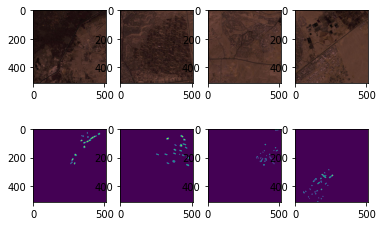

In [69]:
print('Showing the orginal data:')
f, ax = plt.subplots(2,4)
ax[0,0].imshow(imgs_train[0])
ax[1,0].imshow(label_train[0])
ax[0,1].imshow(imgs_train[1])
ax[1,1].imshow(label_train[1])
ax[0,2].imshow(imgs_train[2])
ax[1,2].imshow(label_train[2])
ax[0,3].imshow(imgs_train[3])
ax[1,3].imshow(label_train[3])

plt.show()


In [ ]:
crop_imgs = [imgs_train[0][0:300, 200:500],imgs_train[1][0:300, 200:500],imgs_train[2][0:300, 200:500],imgs_train[3][200:500, 0:300]]
crop_labels = [label_train[0][0:300, 200:500],label_train[1][0:300, 200:500],label_train[2][0:300, 200:500],label_train[3][200:500, 0:300]]


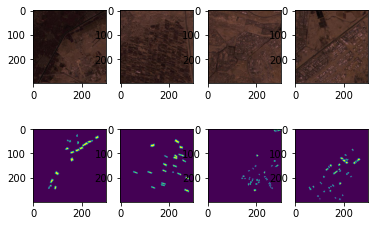

In [101]:
f, ax = plt.subplots(2,4)
ax[0,0].imshow(crop_imgs[0])
ax[1,0].imshow(crop_labels[0])
ax[0,1].imshow(crop_imgs[1])
ax[1,1].imshow(crop_labels[1])
ax[0,2].imshow(crop_imgs[2])
ax[1,2].imshow(crop_labels[2])
ax[0,3].imshow(crop_imgs[3])
ax[1,3].imshow(crop_labels[3])

plt.show()


In [100]:
imgs_test = [crop_imgs[3]]

In [45]:
#improved
def extract_features(img, img_gary, label, train, lbp_radius = 10, lbp_points_ratio = 4, h_neighbors = 11, num_examples = 10000):
  '''
  extract above 13 features
  '''

  #1.  RGB values have beed extracted when loading the orignal dataset --img--
  #2.  Local Binary Pattern https://www.researchgate.net/figure/Local-binary-patterns-LBP-texture-a-Principle-of-LBP-b-LBP-texture-of-the-canopy_fig4_323741245
  def LBP(img,points,radius):
    '''
     points: Number of circularly symmetric neighbour set points 
     radius: Radius of circle
    '''
    #print(' extracting local binary pattern features.')
    lbp = feature.local_binary_pattern(img, points, radius)
    return (lbp-np.min(lbp))/(np.max(lbp)-np.min(lbp)) * 255
  
  #3. Haralick's texture features https://gogul.dev/software/texture-recognition
  #https://www.dovepress.com/application-of-haralick-texture-features-in-brain-18f-florbetapir-posi-peer-reviewed-fulltext-article-CIA
  def HTF(img, h_neighbors, ss_dix):
    '''
    h_neighbors:
    '''
    #print(' extracting haralick texture features.')
    size = h_neighbors
    shape = (img.shape[0] - size + 1, img.shape[1] - size + 1, size, size)
    # should be equal to the size of feature_img = feature_img[h_index:-h_index, h_index:-h_index]
    strides = 2 * img.strides
    patches = stride_tricks.as_strided(img, shape=shape, strides = strides)
    patches = patches.reshape(-1,size,size)
    
    if len(ss_idx) == 0:
      bar = progressbar.ProgressBar(maxval = len(patches), \
                                   widgets = [progressbar.Bar('=','[', ']'), ' ', progressbar.Percentage()])
    else:
      bar = progressbar.ProgressBar(maxval=len(ss_idx), \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    
    
    def calculate_haralick(img):
      '''
      calculate haralick features for each patch
      '''
      features = []
      
      feature_ = mt.features.haralick(img)
      mean_ = feature_.mean(axis=0)
      
      [features.append(i) for i in mean_[0:9]]
      
      return np.array(features)
    
   
    bar.start()
    h_features = []
    
    if len(ss_idx) == 0:
      for i, p in enumerate(patches):
        bar.update(i+1)
        h_features.append(calculate_haralick(p))
    else:
      for i, p in enumerate(patches[ss_idx]):
        bar.update(i+1)
        h_features.append(calculate_haralick(p))
    
    return np.array(h_features)
  
  
  #4. extracting all the features
  
  # Hyperparameters:
  lbp_points = lbp_radius*lbp_points_ratio # number of circularly symmetric neighbour set points 
  
  
  #num_examples = 1000 # number of examples (pixels) per image to use for training model
  h_index = int((h_neighbors -1)/2)
  feature_img = np.zeros((img.shape[0], img.shape[1],4))
  feature_img[:,:,:3] = img
  feature_img[:,:,3] = LBP(img_gary, lbp_points, lbp_radius)
  feature_img = feature_img[h_index:-h_index, h_index:-h_index]
  s = feature_img.shape
  features = feature_img.reshape((s[0]*s[1], s[2]))
  
  if train:
    ss_idx = np.random.randint(0,features.shape[0],num_examples)
    features = features[ss_idx]
  else:
    ss_idx = []
  
  h_features = HTF(img_gary, h_neighbors, ss_idx)
  features = np.hstack((features, h_features))
  
  if train:
    label = label[h_index:-h_index, h_index:-h_index]
    labels = label.reshape(label.shape[0]*label.shape[1],1)
    labels = labels[ss_idx]
  else:
    labels = None
 
  return features, labels


In [46]:
def generate_training_data(imgs_train, label_train, train,
                           lbp_radius = 10, lbp_points_ratio = 4,
                           h_neighbors = 11, num_examples = 10000):
  start_time = time.time()  
  print("_"*30)
  print("[INFO] Extracting features from original image(s)")
  
  Features = []
  Labels = []
  
  for i, img in enumerate(imgs_train):
    img_gary = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features, labels = extract_features(img,img_gary,label_train[i], train = train,
                                        lbp_radius = 10, lbp_points_ratio = 4,
                                        h_neighbors = 11, num_examples = 10000)
    Features.append(features)
    Labels.append(labels)
    
  Features = np.array(Features)
  s = Features.shape
  Features = Features.reshape((s[0]*s[1],s[2]))
  Labels = np.array(Labels)
  s = Labels.shape
  Labels = Labels.reshape((s[0]*s[1],s[2]))
  Labels = Labels.ravel()
  Labels[Labels==255] =1
  
  print("_"*30)
  print("[INFO] check the size of generated training data")
  print('size of the feature vector: {}'.format(Features.shape))
  print('size of the label vertor: {}'.format(Labels.shape))
  end_time = time.time()
  print('Extracting features time: %.4f s' %(end_time-start_time))
  #np.save('drive/data/X.npy',Features)
  #np.save('drive/data/Y.npy', Labels)
  
  return Features, Labels

In [88]:
X, Y = generate_training_data(crop_imgs, crop_labels, train=True)

[                                                                        ] N/A%

______________________________
[INFO] Extracting features from original image(s)


[======================================================================= ]  98%

______________________________
[INFO] check the size of generated training data
size of the feature vector: (40000, 13)
size of the label vertor: (40000,)
Extracting features time: 101.0999 s


In [ ]:
def train(train_X, train_Y, classifier):
  
  start_time = time.time()
  
  if classifier == "SVM":
    print("_"*30)
    print ('[INFO] Training a Support Vector Machine model.')
    model = SVC(kernel = 'RBF')
  elif classifier == "RF":
    print("_"*30)
    print('[INFO] Training a Random Forest model.')
    model = RandomForestClassifier(n_estimators=15, criterion = 'entropy', max_features = 'auto',
                                     max_depth=8, min_samples_split = 3, min_samples_leaf = 18, random_state=42, bootstrap = 'True')
  elif classifier == "DT":
    print("_"*30)
    print('[INFO] Training a Decision Tree model.')
    model = DecisionTreeClassifier(criterion = "gini",
            random_state = 100,max_depth=3, min_samples_leaf=5)
    
    
  model.fit(train_X, train_Y)
    
  end_time = time.time()

  
  print("_"*30)
  print('[INFO] Training complete.')
  print('training time: %.4f s' %(end_time-start_time))
  
  return model


In [89]:
#train_X, test_X, train_Y, test_Y = train_test_split(X,Y,test_size=0.3, random_state=42) 

In [90]:
#model_SVM = train(train_X, train_Y, classifier='SVM')

In [98]:
model_DT = train(X, Y, classifier='DT')

______________________________
[INFO] Training a Decision Tree model.
______________________________
[INFO] Training complete.
training time: 0.3304 s


In [99]:
model_RF = train(X, Y, classifier='RF')

______________________________
[INFO] Training a Random Forest model.
______________________________
[INFO] Training complete.
training time: 9.0377 s


In [93]:
def test(test_X, test_Y,model_used):
  
  

    pred = model_used.predict(test_X)
    precision = metrics.precision_score(test_Y, pred, average='macro', labels=np.unique(pred))
    accuracy = metrics.accuracy_score(test_Y, pred)
    print ('_'*30)
    print('[RESULTS] Testing...')
    print ('Accuracy: %.4f' %accuracy)
    print ('Precision: %.4f' %precision)
    
 


In [94]:
test(test_X, test_Y,model_RF)


______________________________
[RESULTS] Testing...
Accuracy: 0.9600
Precision: 0.9600


In [95]:
test(test_X, test_Y,model_DT)


______________________________
[RESULTS] Testing...
Accuracy: 0.9600
Precision: 0.9600


In [ ]:
#filename = './RF_model_100_live.pkl'
#with open(filename, 'wb') as file:  
#    pickle.dump(model_RF, file)

In [ ]:
#pkl_filename = './RF_model.pkl'
#with open(pkl_filename, 'rb') as file:  
#    loaded_model_RF = pickle.load(file)

In [96]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

def inference(imgs_test, h_neighbors,classifier):
  start_time = time.time()

  print("_"*30)
  print('[INFO] Doing inference on test images...')
  print('loading trained model.')
  
  border = int((h_neighbors-1)/2)
  Feature = []
  img_list=[]
  print('infer for each image')
  model=classifier
  for img in imgs_test:
    img = cv2.copyMakeBorder(img, top=border, bottom=border, \
                                  left=border, right=border, \
                                  borderType = cv2.BORDER_CONSTANT, \
                                  value=[0, 0, 0])

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    features, _ = extract_features(img, img_gray, label=None, train=False)
    Feature.append(features)
    
   
    
    prediction = model.predict(features.reshape((-1, features.shape[1])))
    size_pred = int(math.sqrt(features.shape[0]))
    pred_img = prediction.reshape(size_pred, size_pred)
    img_list.append(pred_img)
    
     

  end_time = time.time() 
  print('predection time: %.4f s' %(end_time-start_time)) 
    
  return img_list


In [102]:
pred_rf=inference(imgs_test, h_neighbors = 11,classifier=model_DT)

[                                                                        ] N/A%

______________________________
[INFO] Doing inference on test images...
loading trained model.
infer for each image


[======================================================================= ]  98%

predection time: 260.0024 s


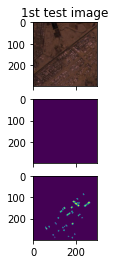

In [108]:
f, ax = plt.subplots(3,1, sharex=True)
ax[0].imshow(imgs_test[0])
ax[0].set_title('1st test image')
ax[1].imshow(pred_rf[0])
ax[2].imshow(crop_labels[3])
plt.show()